In [ ]:
  !pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.0 MB/s eta 0:00:00


BERT Pre-trained model

Imoporting transformers library from Hugging face. BertTokenizer converts the input text into tokens that correspond to the BERT model's vocabulary. BertForSequenceClassification used for task classification, It outputs logits which you can then pass through a softmax layer to get the probabilities for each class.


Import necessary libraries



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score


 Load and prepare the data

In [ ]:
df = pd.read_csv("/content/IMDB Dataset.csv")
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

train, val = train_test_split(df, test_size=0.1)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)


Define the Dataset class for handling the data

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer #used to convert the raw text into tokens that can be used by the model.
        self.data = data #contains the reviews and their corresponding sentiment values.
        self.text = data.review
        self.targets = data.sentiment
        self.max_len = max_len #sequence max length, longer sequence gets truncated, shorter one's are padded.

    def __len__(self):
        return len(self.text) #returns samples in dataset

    def __getitem__(self, index):
        text = str(self.text[index]) #Retrieve the text at the specified index
        text = " ".join(text.split())
# convert the text into tokens, does padding, truncation, create attention masks
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
#returns dictionary with preprocessed tokens,attention masks, token type ids, target sentiment
        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }


Set up the BERT tokenizer, model, loss function, and optimizer

Base model is 12 layer, 768 hidden, 12 heads, 110 parameter neural network architecture

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") #This is used to convert the input text into tokens that correspond to the BERT model's vocabulary.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased") #This is a BERT model transformer specifically designed for classification tasks. It outputs logits which you can then pass through a softmax layer to get the probabilities for each class.

loss_fn = torch.nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=0.00001)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Word Embeddings:** we convert every word into list of numbers that represents meaning of word.
**Position Embeddings:** BERT needs to understand the order of sentence as order can change meaning,thats why we give each word a code that represnts the position in sentence.
**Token Type Embeddings:** IF i want to look at 2 sentences at a time, we give another code that shows which sentence each word belong to.
**Layers:** BERT uses layers to look at a sentence in different perspective, each time it learns new info from sentence.
**Attention:** in each layer BERT uses attention to focus on different parts of sentence.
**Intermediate and Output:** Inside each layer, BERT processes what it learned from the attention step and get ready for the next layer.
**Pooler:** once all layers are done, pooler takes everthing it learned and squash it into a single list of numbers.
**Dropout:** It uses dropout to forget things randomly.
**Classifier:** Once reading data and processing is done, then classifier makes final decision i.e choosing correct answer.

**How BERT understands the sentence:**
When BERT reads a sentence it creates 3 keys, 'query', 'key', 'value'. 'Query' in BERt is a question about sentence where 'key' is used to calculate score between BERTs question and every match in a sentence whereas 'value' is actual content of each word.

In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Prepare the data loaders

In [ ]:

train_dataset = IMDBDataset(train, tokenizer, 128)
val_dataset = IMDBDataset(val, tokenizer, 128)

batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)


Train and validate the model

Foreach epoch, we first trains on the training data, we will compute loss and backpropagating the gradients. Then, we will evaluate on the validation data. During training it keeps track of training and validation loss and accuracy for each epoch. The goal is to minimize the loss and maximize the accuracy, thus improving the model's predictions.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

train_loss_set = []
val_loss_set = []
train_acc_set = []
val_acc_set = []
epochs = 10

# Training
for epoch in tqdm(range(epochs), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    train_acc = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch['ids'].to(device)
        b_labels = batch['targets'].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=(b_input_ids > 0).int(), labels=b_labels.long())
        loss = outputs[0]
        logits = outputs[1]

        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        train_acc += (logits.argmax(-1) == b_labels).sum().item()
    train_loss = tr_loss / nb_tr_steps
    train_accuracy = train_acc / nb_tr_examples
    train_acc_set.append(train_accuracy)
    train_loss_set.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    val_acc = 0
    nb_val_examples, nb_val_steps = 0, 0
    for batch in validation_dataloader:
        b_input_ids = batch['ids'].to(device)
        b_labels = batch['targets'].to(device)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=(b_input_ids > 0).int(), labels=b_labels.long())
        loss = outputs[0]
        logits = outputs[1]

        val_loss += loss.item()
        nb_val_examples += b_input_ids.size(0)
        nb_val_steps += 1
        val_acc += (logits.argmax(-1) == b_labels).sum().item()
    val_accuracy = val_acc / nb_val_examples
    avg_val_loss = val_loss / nb_val_examples
    val_loss_set.append(avg_val_loss)
    val_acc_set.append(val_accuracy)

    print("Epoch {} - Train loss: {:.4f}, Train accuracy: {:.4f}, Validation loss: {:.4f}, Validation accuracy: {:.4f}"
          .format(epoch, train_loss, train_accuracy, val_loss / nb_val_steps, val_accuracy))


Epoch:  10%|█         | 1/10 [21:49<3:16:26, 1309.57s/it]

Epoch 0 - Train loss: 0.3186, Train accuracy: 0.8621, Validation loss: 0.2693, Validation accuracy: 0.8902


Epoch:  20%|██        | 2/10 [43:17<2:52:53, 1296.67s/it]

Epoch 1 - Train loss: 0.2128, Train accuracy: 0.9135, Validation loss: 0.2796, Validation accuracy: 0.8906


Epoch:  30%|███       | 3/10 [1:04:43<2:30:44, 1292.11s/it]

Epoch 2 - Train loss: 0.1393, Train accuracy: 0.9471, Validation loss: 0.2958, Validation accuracy: 0.8916


Epoch:  40%|████      | 4/10 [1:26:09<2:08:56, 1289.39s/it]

Epoch 3 - Train loss: 0.0806, Train accuracy: 0.9718, Validation loss: 0.3604, Validation accuracy: 0.8930


Epoch:  50%|█████     | 5/10 [1:47:26<1:47:05, 1285.11s/it]

Epoch 4 - Train loss: 0.0507, Train accuracy: 0.9828, Validation loss: 0.4626, Validation accuracy: 0.8856


Epoch:  60%|██████    | 6/10 [2:08:44<1:25:31, 1282.76s/it]

Epoch 5 - Train loss: 0.0356, Train accuracy: 0.9885, Validation loss: 0.4588, Validation accuracy: 0.8870


Epoch:  70%|███████   | 7/10 [2:30:02<1:04:02, 1280.99s/it]

Epoch 6 - Train loss: 0.0268, Train accuracy: 0.9918, Validation loss: 0.4935, Validation accuracy: 0.8908


Epoch:  80%|████████  | 8/10 [2:51:15<42:37, 1278.69s/it]  

Epoch 7 - Train loss: 0.0222, Train accuracy: 0.9927, Validation loss: 0.4869, Validation accuracy: 0.8984


Epoch:  90%|█████████ | 9/10 [3:12:28<21:16, 1276.85s/it]

Epoch 8 - Train loss: 0.0201, Train accuracy: 0.9934, Validation loss: 0.5141, Validation accuracy: 0.8920


Epoch: 100%|██████████| 10/10 [3:33:42<00:00, 1282.21s/it]

Epoch 9 - Train loss: 0.0160, Train accuracy: 0.9952, Validation loss: 0.5118, Validation accuracy: 0.8966


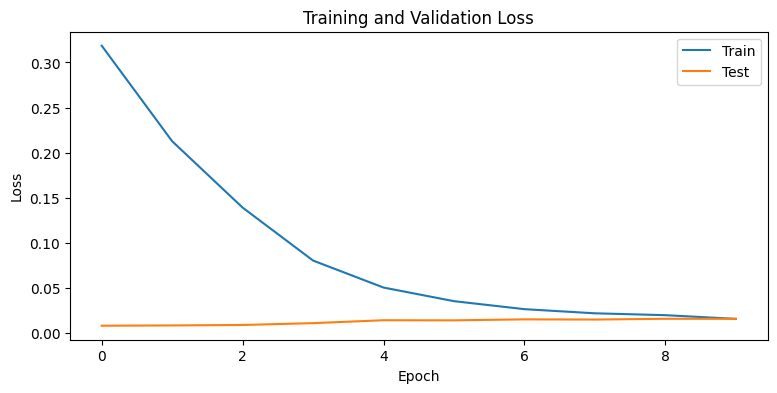

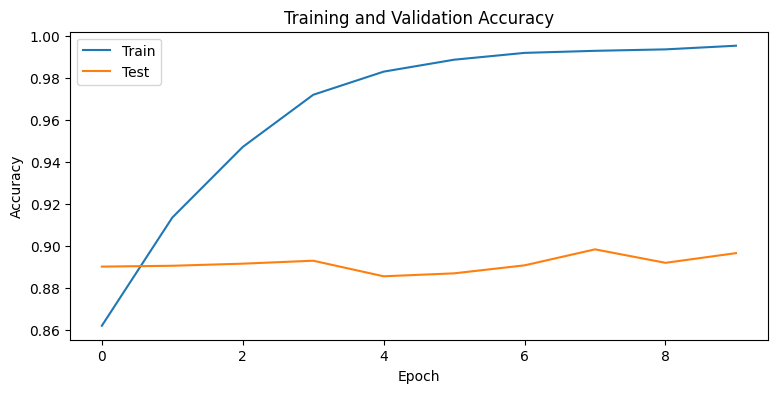

In [ ]:
# Training and validation loss plots
plt.figure(figsize=(9,4))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_loss_set, label="Train")
plt.plot(val_loss_set, label="Test")
plt.legend()
plt.show()

# Training and validation accuracy plots
plt.figure(figsize=(9,4))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_acc_set, label="Train")
plt.plot(val_acc_set, label="Test")
plt.legend()
plt.show()


In [ ]:
from torch.nn.functional import softmax

def predict_sentiment_bert(model, tokenizer, sequence):

    inputs = tokenizer.encode_plus(
        sequence,
        add_special_tokens=True,
        max_length=512,
        return_tensors='pt',
        pad_to_max_length=True,
        truncation=True
    ).to(device)


    with torch.no_grad():
        outputs = model(inputs['input_ids'], token_type_ids=None, attention_mask=inputs['attention_mask'])


    probs = softmax(outputs[0], dim=-1)


    prediction = torch.argmax(probs, dim=-1).item()

    return 'positive' if prediction == 1 else 'negative'


In [ ]:

random_samples = df.sample(10)

# we wil finally Predict sentiment for each sentence
for i, row in random_samples.iterrows():
    sentence = row['review']
    actual_sentiment = 'positive' if row['sentiment'] == 1 else 'negative'
    predicted_sentiment = predict_sentiment_bert(model, tokenizer, sentence)

    print(f"Sentence {i+1}: {sentence[:250]}...")
    print(f"Actual Sentiment: {actual_sentiment}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print("-"*50)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Sentence 38138: Once again, I was browsing through the discount video bin and picked up this movie for $4.88. Fifty-percent of the time the movies I find in the bin are pure crap (I mean horrible beyond belief) but half the time they turn out to be surprisingly good...
Actual Sentiment: positive
Predicted Sentiment: positive
--------------------------------------------------
Sentence 43235: During the 13 years of schooling I had from Kindergarten through high school, there was only one day that my class took a field trip. When I went to school, you went to school, from 8:30 until 3:30 and filed trips were not taken. But, for some reason...
Actual Sentiment: positive
Predicted Sentiment: positive
--------------------------------------------------
Sentence 44811: My partner and I sat down to watch this film over a bottle of wine last Saturday and although we initially had our reservations once the story got going it was in actual fact rather gripping. The scene in which one of the charac